In [4]:
import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.binary import *

from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7)
#w = cluster.scale(jobs=10)
w = cluster.scale(jobs=2)
#
client = Client(cluster)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


---

# extraction from binary files

In [6]:
out_dir = datawork+'/iwsst_mit/'

fs = LocalFileSystem()
def extract(v, it, face, i, j, pref=''):
    
    store = llcreader.BaseStore(fs, base_path=bin_data_dir+v+'/', 
                                shrunk=True, mask_path=mask_path)
    model = llcreader.LLC4320Model(store)
    ds = model.get_dataset(varnames=[v])
    
    file_out = out_dir+pref+v+'.nc'
    #ds[v].isel(time=t, face=face, i=i, j=j).to_netcdf(file_out, mode='w', unlimited_dims='time')
    dv = ds[v].sel(time=time.sel(iters=it)).isel(face=face, i=i, j=j)
    dv = dv.load()
    dv.to_netcdf(file_out, mode='w', unlimited_dims='time')


In [2]:
V = ['Eta', 'SST', 'SSU', 'SSV']
#V = ['Eta', 'SST']
#V = ['SSU']


iters, time = get_iters_time('Eta', bin_data_dir+'Eta/', delta_t=25.)
siters = iters.sel(time=slice(152*86400.,178*86400.))

ext = {}
ext['mad'] = {'iters': siters, 'face': 1, 'i': slice(3000,None), 'j': slice(1000,4000)}
ext['nwa'] = {'iters': siters, 'face': 4, 'i': slice(2000,4000), 'j': slice(1500,3500)}

for key, e in ext.items():
    print('face = %d' %e['face'])
    for v in V:
        print(v)
        #extract(v, e['iters'], e['face'], e['i'], e['j'], pref=key+'_')

face = 1
Eta
SST
SSU
SSV
face = 4
Eta
SST
SSU
SSV


---

# manual exploration in order to get index slices

In [8]:
v = 'Eta'
data_dir = bin_data_dir+v+'/'
iters, time = get_iters_time(v, data_dir, delta_t=25.)


store = llcreader.BaseStore(fs, base_path=bin_data_dir+v+'/', 
                            shrunk=True, mask_path=mask_path)
model = llcreader.LLC4320Model(store)
ds = model.get_dataset(varnames=[v])

print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chu

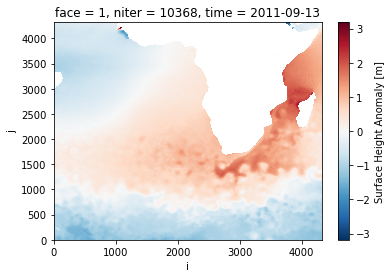

In [9]:
ds[v].isel(time=0, face=1).plot()

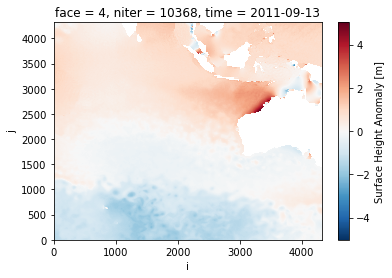

In [10]:
ds[v].isel(time=0, face=4).plot()

### produce a netcdf file

In [ ]:
ds.isel(time=slice(0,24), face=1)

In [ ]:
file_out = datawork+'/ssh_extract.nc'
#ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
ds[v].isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time')

---

In [ ]:
# kill scheduler, workers
cluster.close()